In [1]:
DRY_RUN = True

In [2]:
import pandas as pd

In [3]:
if not DRY_RUN:
    transactions = pd.read_parquet('data/transactions_train.parquet')
    customers = pd.read_parquet('data/customers.parquet')
    articles = pd.read_parquet('data/articles.parquet')
else:
    print("loading sample data")
    sample = 0.05
    transactions = pd.read_parquet(f'data/transactions_train_sample_{sample}.parquet')
    customers = pd.read_parquet(f'data/customers_sample_{sample}.parquet')
    articles = pd.read_parquet(f'data/articles_train_sample_{sample}.parquet')

loading sample data


In [4]:
transactions.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2018-09-20,27523763215971119,573937001,0.032186,2,0
1,2018-09-20,42558275223080816,639894003,0.016932,2,0


In [5]:
customers.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,11133958332576663613,-1,-1,0,0,47,0
1,8926696106003907460,-1,-1,1,0,59,761


In [6]:
articles.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,12855,253,9,0,1010016,0,9,0,...,10,0,0,1,0,16,30,1002,2,8834
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,10,0,0,1,0,16,30,1002,2,8834


In [7]:
test_week = transactions.week.max()
transactions.week.max(), transactions.week.nunique()

(104, 105)

In [8]:
transactions = transactions[transactions.week > transactions.week.max() - 10]

In [9]:
transactions.head(3)

,t_dat,customer_id,article_id,price,sales_channel_id,week
1461348,2020-07-15,15802575927082305,838809001,0.016932,2,95
1461349,2020-07-15,15802575927082305,824813001,0.016932,2,95
1461350,2020-07-15,15802575927082305,888331011,0.025407,2,95


### Generating Candidates

The records I generate below can both be used as candidates for evaluation by our ranker (for the test week) and as negative examples (for training data).

I am going with the name candidates for both of these use cases, but that is certainly not ideal. Feel free to refactor the naming to increase the clarity of your code.

#### Last Purchase Candidates

In [10]:
c2weeks = transactions.groupby('customer_id')['week'].unique()
c2weeks[:3]

customer_id
116809474287335    [101, 103]
519262836338427         [102]
805095543045062         [102]
Name: week, dtype: object

In [11]:
c2weeks2shifted_weeks = {}

# obtain the {current_week_purchase : next_week_purchase} for each customer
for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week

In [12]:
c2weeks2shifted_weeks[116809474287335]

{101: 103, 103: 104}

In [13]:
# candindate_next_purchase will contain the week value for next purchase
candidates_last_purchase = transactions.copy()

In [14]:
candidates_last_purchase.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,week
1461348,2020-07-15,15802575927082305,838809001,0.016932,2,95
1461349,2020-07-15,15802575927082305,824813001,0.016932,2,95


In [15]:
weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    # for each trasactions, append next week trasaction to weeks list
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase.week=weeks

In [16]:
display(transactions.head(2))
candidates_last_purchase.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,week
1461348,2020-07-15,15802575927082305,838809001,0.016932,2,95
1461349,2020-07-15,15802575927082305,824813001,0.016932,2,95


,t_dat,customer_id,article_id,price,sales_channel_id,week
1461348,2020-07-15,15802575927082305,838809001,0.016932,2,97
1461349,2020-07-15,15802575927082305,824813001,0.016932,2,97


### Best Sellers Candidates

In [17]:
mean_price = transactions.groupby(['week', 'article_id'])['price'].mean()

In [18]:
### understand
mean_price[:5]

week  article_id
95    111565001     0.002530
      111586001     0.010017
      111609001     0.008458
      123173001     0.005237
      129085001     0.006085
Name: price, dtype: float32

In [19]:
### understand
transactions.groupby('week')['article_id'].value_counts()[:3]

week  article_id
95    760084003     32
      817354001     29
      372860002     28
Name: count, dtype: int64

In [20]:
# obtain the number of sales of each article for each week
sales = transactions.groupby('week')['article_id'].value_counts()
display(sales[:5]) 
# rank the articles within each week based on the sales number
sales = sales.groupby('week').rank(method='dense', ascending=False)
display(sales[:5])
# obtain the top 12 articles and rename the series as bestseller_rank
sales = sales.groupby('week').head(12).rename('bestseller_rank')
display(sales[:5])

week  article_id
95    760084003     32
      817354001     29
      372860002     28
      816423004     26
      600886001     24
Name: count, dtype: int64

week  article_id
95    760084003     1.0
      817354001     2.0
      372860002     3.0
      816423004     4.0
      600886001     5.0
Name: count, dtype: float64

week  article_id
95    760084003     1.0
      817354001     2.0
      372860002     3.0
      816423004     4.0
      600886001     5.0
Name: bestseller_rank, dtype: float64

In [21]:
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
# +1 done to make the bestseller rank and mean price for previous week
# i.e to know the bestseller and mean price of each article in the previous week
bestsellers_previous_week.week += 1
bestsellers_previous_week[:5]

,week,article_id,bestseller_rank,price
0,96,760084003,1.0,0.025089
1,96,817354001,2.0,0.022332
2,96,372860002,3.0,0.013152
3,96,816423004,4.0,0.025329
4,96,600886001,5.0,0.022944


Here We obtained the **Rank on the basis of sales number for each article sold on a week(TOP 12)** and **mean price for each article in that week** 

In [22]:
### understand
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
1461348,2020-07-15,15802575927082305,838809001,0.016932,2,95
1461349,2020-07-15,15802575927082305,824813001,0.016932,2,95
1461350,2020-07-15,15802575927082305,888331011,0.025407,2,95
1461351,2020-07-15,15802575927082305,888331011,0.025407,2,95
1461352,2020-07-15,15802575927082305,890107002,0.015237,2,95


In [23]:
unique_transactions = transactions \
                            .groupby(['week', 'customer_id']) \
                            .head(1) \
                            .drop(columns=['article_id', 'price']) \
                            .copy()

unique_transactions.head()

,t_dat,customer_id,sales_channel_id,week
1461348,2020-07-15,15802575927082305,2,95
1461355,2020-07-15,22938593259428180,2,95
1461357,2020-07-15,29243526950884932,2,95
1461361,2020-07-15,35199320161848364,1,95
1461371,2020-07-15,47701219751131151,2,95


In [24]:
candidates_bestsellers = pd.merge(
    unique_transactions,
    bestsellers_previous_week,
    on='week',
    how="inner"
)
candidates_bestsellers.head()

,t_dat,customer_id,sales_channel_id,week,article_id,bestseller_rank,price
0,2020-07-22,111958755318697281,2,96,760084003,1.0,0.025089
1,2020-07-22,111958755318697281,2,96,817354001,2.0,0.022332
2,2020-07-22,111958755318697281,2,96,372860002,3.0,0.013152
3,2020-07-22,111958755318697281,2,96,816423004,4.0,0.025329
4,2020-07-22,111958755318697281,2,96,600886001,5.0,0.022944


In [25]:
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [26]:
test_set_transactions.head(2)

,t_dat,customer_id,sales_channel_id,week
0,2020-07-15,15802575927082305,2,104
1,2020-07-15,22938593259428180,2,104


In [27]:
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week',
    how="inner"
)
candidates_bestsellers_test_week.head()

,t_dat,customer_id,sales_channel_id,week,article_id,bestseller_rank,price
0,2020-07-15,15802575927082305,2,104,909370001,1.0,0.032440
1,2020-07-15,15802575927082305,2,104,865799006,2.0,0.033151
2,2020-07-15,15802575927082305,2,104,918522001,3.0,0.041197
3,2020-07-15,15802575927082305,2,104,924243001,4.0,0.041799
4,2020-07-15,15802575927082305,2,104,751471001,5.0,0.033173


In [28]:
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

In [29]:
candidates_bestsellers.head()

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2020-07-22,111958755318697281,2,96,760084003,0.025089
1,2020-07-22,111958755318697281,2,96,817354001,0.022332
2,2020-07-22,111958755318697281,2,96,372860002,0.013152
3,2020-07-22,111958755318697281,2,96,816423004,0.025329
4,2020-07-22,111958755318697281,2,96,600886001,0.022944


### Combining transactions and candidates / Negative Examples

In [30]:
transactions['purchased'] = 1

In [31]:
transactions.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
1461348,2020-07-15,15802575927082305,838809001,0.016932,2,95,1
1461349,2020-07-15,15802575927082305,824813001,0.016932,2,95,1


In [32]:
candidates_last_purchase.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,week
1461348,2020-07-15,15802575927082305,838809001,0.016932,2,97
1461349,2020-07-15,15802575927082305,824813001,0.016932,2,97


In [33]:
candidates_bestsellers.head(2)

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2020-07-22,111958755318697281,2,96,760084003,0.025089
1,2020-07-22,111958755318697281,2,96,817354001,0.022332


In [34]:
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers])
data.purchased.fillna(0, inplace=True)
data.purchased.mean()

/tmp/ipykernel_5500/352231391.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.purchased.fillna(0, inplace=True)


0.1474983350423375

#### Add bestseller information

In [35]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
1461348,2020-07-15,15802575927082305,838809001,0.016932,2,95,1.0
1461349,2020-07-15,15802575927082305,824813001,0.016932,2,95,1.0
1461350,2020-07-15,15802575927082305,888331011,0.025407,2,95,1.0
1461351,2020-07-15,15802575927082305,888331011,0.025407,2,95,1.0
1461352,2020-07-15,15802575927082305,890107002,0.015237,2,95,1.0


In [36]:
data = pd.merge(
    data, 
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

In [37]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank
0,2020-07-15,15802575927082305,838809001,0.016932,2,95,1.0,NaN
1,2020-07-15,15802575927082305,824813001,0.016932,2,95,1.0,NaN
2,2020-07-15,15802575927082305,888331011,0.025407,2,95,1.0,NaN
3,2020-07-15,15802575927082305,888331011,0.025407,2,95,1.0,NaN
4,2020-07-15,15802575927082305,890107002,0.015237,2,95,1.0,NaN


In [38]:
data.week.min()

95

In [39]:
data = data[data.week != data.week.min()].copy()
data.bestseller_rank.fillna(999, inplace=True)

/tmp/ipykernel_5500/522987596.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.bestseller_rank.fillna(999, inplace=True)


In [40]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank
15277,2020-07-22,111958755318697281,811679001,0.015237,2,96,1.0,999.0
15278,2020-07-22,111958755318697281,728473002,0.011847,2,96,1.0,999.0
15279,2020-07-22,111958755318697281,850791001,0.022017,2,96,1.0,999.0
15280,2020-07-22,111958755318697281,872475001,0.033881,2,96,1.0,999.0
15281,2020-07-22,111958755318697281,854683003,0.005068,2,96,1.0,999.0


In [41]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [42]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2020-07-22,111958755318697281,811679001,0.015237,2,96,1.0,999.0,811679,27664,...,3,1014,17,24544,-1,-1,0,0,20,152948
1,2020-07-22,111958755318697281,728473002,0.011847,2,96,1.0,999.0,728473,5068,...,22,1018,12,11600,-1,-1,0,0,20,152948
2,2020-07-22,111958755318697281,850791001,0.022017,2,96,1.0,999.0,850791,22091,...,3,1014,17,16248,-1,-1,0,0,20,152948
3,2020-07-22,111958755318697281,872475001,0.033881,2,96,1.0,999.0,872475,26918,...,3,1014,17,31168,-1,-1,0,0,20,152948
4,2020-07-22,111958755318697281,854683003,0.005068,2,96,1.0,999.0,854683,5429,...,22,1018,12,6093,-1,-1,0,0,20,152948


In [43]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [44]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [45]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [46]:
train_baskets

array([15, 16, 14, ..., 17, 16, 32])

In [47]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [48]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [49]:
train_X.head()

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
0,621073001,66,1010016,10,3,9,4920,0,1,97,1001,-1,-1,0,0,33,70490,999.0
1,621073001,66,1010016,10,3,9,4920,0,1,97,1001,-1,-1,0,0,33,70490,999.0
2,868258001,306,1010016,10,3,9,1334,7,1,61,1017,-1,-1,0,0,33,70490,999.0
3,760084003,272,1010016,9,4,5,1747,1,2,53,1009,-1,-1,0,0,33,70490,1.0
4,817354001,264,1010016,19,4,11,1222,0,1,15,1008,-1,-1,0,0,33,70490,2.0


### Model Training

In [50]:
from lightgbm.sklearn import LGBMRanker

/home/niranjan/miniconda3/envs/fashion-rec-sys/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 10.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [51]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1000,
    importance_type='gain',
    verbose=10
)

In [52]:
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.108572
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.005982 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 531990, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a t

In [53]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.8371075331679341
article_id 0.03653977670133205
product_type_no 0.02088374840116998
postal_code 0.020697952668731517
department_no 0.01863327796025292
age 0.016495419194318392
colour_group_code 0.011448332438465138
garment_group_no 0.00925132868051138
graphical_appearance_no 0.007393426583081934
section_no 0.006210043528207792
perceived_colour_master_id 0.005785161975396816
perceived_colour_value_id 0.0037814042981748073
index_code 0.0018217356458305066
index_group_no 0.0014593290585391055
FN 0.0008060848188253779
club_member_status 0.0006031614103536691
Active 0.0005982650851928807
fashion_news_frequency 0.0004840183836816183


In [54]:
import numpy as np

In [55]:
sorted_indices = np.argsort(-ranker.feature_importances_)
sorted_columns = np.array(columns_to_use)[sorted_indices]
sorted_importances = ranker.feature_importances_[sorted_indices]

In [56]:
import matplotlib.pyplot as plt

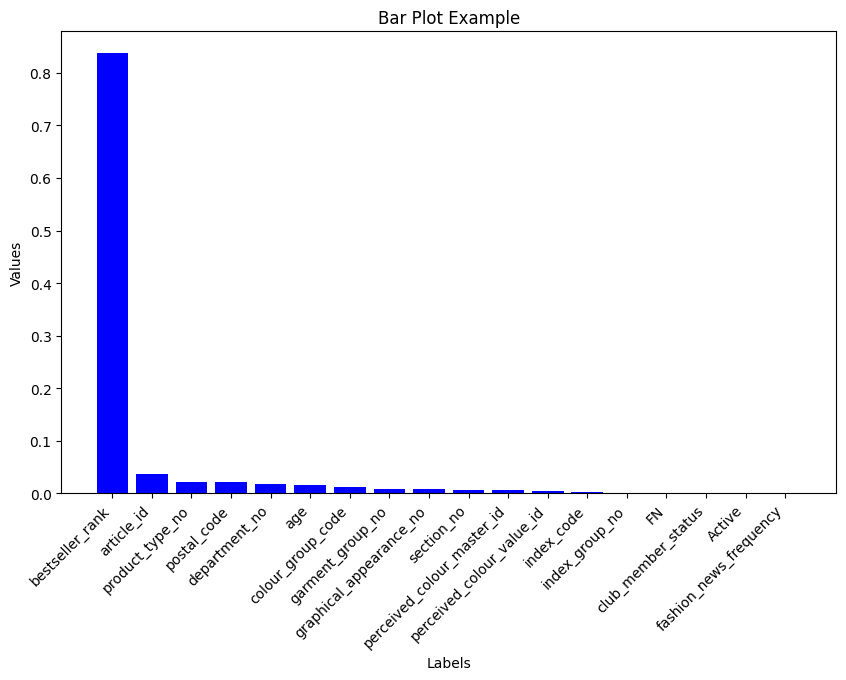

In [57]:
plt.figure(figsize=(10, 6))
plt.bar(sorted_columns, sorted_importances / sorted_importances.sum(), color='blue')

# Adding title and labels
plt.title('Bar Plot Example')
plt.xlabel('Labels')
plt.ylabel('Values')

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [58]:
test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = ['0' + str(a_id) for a_id in \
                             bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()]

In [59]:
test['preds'][:3]

531990    2.021297
531991   -5.539018
531992   -5.468175
Name: preds, dtype: float64